In [1]:
# %matplotlib notebook
import math
import uproot as ur
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   
import k3d
import numpy as np
import awkward as ak


## Get file and TTree, print branches, convert to array

In [2]:
# piplus_events = ur.open("pi+_10GeV_130to177deg.0001.root:events")
piplus_events = ur.open("rec_pionplus.root:events")
pi0_events = ur.open("rec_pion0.root:events")

print(piplus_events.keys())

['mcparticles2', 'mcparticles2/mcparticles2.ID', 'mcparticles2/mcparticles2.g4Parent', 'mcparticles2/mcparticles2.reason', 'mcparticles2/mcparticles2.mask', 'mcparticles2/mcparticles2.steps', 'mcparticles2/mcparticles2.secondaries', 'mcparticles2/mcparticles2.pdgID', 'mcparticles2/mcparticles2.status', 'mcparticles2/mcparticles2.colorFlow[2]', 'mcparticles2/mcparticles2.genStatus', 'mcparticles2/mcparticles2.charge', 'mcparticles2/mcparticles2.spare[1]', 'mcparticles2/mcparticles2.spin[3]', 'mcparticles2/mcparticles2.vsx', 'mcparticles2/mcparticles2.vsy', 'mcparticles2/mcparticles2.vsz', 'mcparticles2/mcparticles2.vex', 'mcparticles2/mcparticles2.vey', 'mcparticles2/mcparticles2.vez', 'mcparticles2/mcparticles2.psx', 'mcparticles2/mcparticles2.psy', 'mcparticles2/mcparticles2.psz', 'mcparticles2/mcparticles2.pex', 'mcparticles2/mcparticles2.pey', 'mcparticles2/mcparticles2.pez', 'mcparticles2/mcparticles2.mass', 'mcparticles2/mcparticles2.time', 'mcparticles2/mcparticles2.properTime', 

In [3]:
print(pi0_events.keys())

['mcparticles2', 'mcparticles2/mcparticles2.ID', 'mcparticles2/mcparticles2.g4Parent', 'mcparticles2/mcparticles2.reason', 'mcparticles2/mcparticles2.mask', 'mcparticles2/mcparticles2.steps', 'mcparticles2/mcparticles2.secondaries', 'mcparticles2/mcparticles2.pdgID', 'mcparticles2/mcparticles2.status', 'mcparticles2/mcparticles2.colorFlow[2]', 'mcparticles2/mcparticles2.genStatus', 'mcparticles2/mcparticles2.charge', 'mcparticles2/mcparticles2.spare[1]', 'mcparticles2/mcparticles2.spin[3]', 'mcparticles2/mcparticles2.vsx', 'mcparticles2/mcparticles2.vsy', 'mcparticles2/mcparticles2.vsz', 'mcparticles2/mcparticles2.vex', 'mcparticles2/mcparticles2.vey', 'mcparticles2/mcparticles2.vez', 'mcparticles2/mcparticles2.psx', 'mcparticles2/mcparticles2.psy', 'mcparticles2/mcparticles2.psz', 'mcparticles2/mcparticles2.pex', 'mcparticles2/mcparticles2.pey', 'mcparticles2/mcparticles2.pez', 'mcparticles2/mcparticles2.mass', 'mcparticles2/mcparticles2.time', 'mcparticles2/mcparticles2.properTime', 

In [4]:
def get_vector(events,varname='HcalEndcapHits',energy='energy'):
    E = events["%s.%s"%(varname,energy)].array(library='np')
    x = events["%s.position.x"%varname].array(library='np')
    y = events["%s.position.y"%varname].array(library='np')
    z = events["%s.position.z"%varname].array(library='np')
#     theta = events["%s.polar.theta"%varname].array(library='np')
#     phi = events["%s.polar.phi"%varname].array(library='np')

    return E,x, y, z, theta, phi

def get_truth(gen_events):
    pdgID = gen_events['mcparticles2.pdgID'].array(library='np')
    status = gen_events['mcparticles2.status'].array(library='np')
    genStatus = gen_events['mcparticles2.genStatus'].array(library='np')
    pex = gen_events['mcparticles2.psx'].array(library='np')
    pey = gen_events['mcparticles2.psy'].array(library='np')
    pez = gen_events['mcparticles2.psz'].array(library='np')
    mass = gen_events['mcparticles2.mass'].array(library='np')

    return pdgID,status, genStatus,pex,pey,pez,mass

In [5]:
E = {}
x = {}
y = {}
z  = {}
theta={}
phi = {}

## Get data

# get hits

In [6]:

for i in ['HcalHadronEndcap','EcalEndcapP']:#,'TrackerEndcap','VertexEndcap']:
    tag = 'piplus_' + i
    E[tag], x[tag], y[tag],z[tag],theta[tag],phi[tag] = get_vector(piplus_events,varname="%sHitsReco"%i)
    tag = 'pi0_' + i
    E[tag], x[tag], y[tag],z[tag],theta[tag],phi[tag] = get_vector(pi0_events,varname="%sHitsReco"%i)

# print(E)
len(x['piplus_EcalEndcapP'])

100

In [7]:
# # np.savez?
# outfile = TemporaryFile()
# x = np.arange(10)
# y = np.sin(x)
# np.savez(outfile, x, y)


## get MC

In [8]:
def get_GeneratedValues(events):
    mc = {} 
    mc['pdgID'], mc['status'], mc['genStatus'], mc['pex'],mc['pey'], mc['pez'], mc['mass']= get_truth(events)
    for i in range(len(mc['pdgID'][0])):
        if(mc['genStatus'][0][i] !=1): continue
        px = mc['pex'][0][i]
        py =  mc['pey'][0][i]
        pz = mc['pez'][0][i]
        pt =  np.sqrt(px*px + py*py)
        p = np.sqrt(px*px+py*py+pz*pz)
        theta = np.arccos(pz/p)*180/np.pi
        ievt = 0
        print('MC particle ID ', mc['pdgID'][ievt][i],  'genStatus ', mc['genStatus'][ievt][i],
               ' px = %2.2f, py=%2.2f, pz=%2.2f'%(mc['pex'][ievt][i],mc['pey'][ievt][i],mc['pez'][ievt][i]))
        print('p = %2.2f , theta =%2.2f'%(p, theta))
    return p, theta

truth = {}
truth['piplus_p'], truth['piplus_theta'] = get_GeneratedValues(piplus_events)
truth['pi0_p'], truth['pi0_theta'] = get_GeneratedValues(pi0_events)



MC particle ID  211 genStatus  1  px = -1.41, py=-3.99, pz=9.07
p = 10.00 , theta =25.00
MC particle ID  111 genStatus  1  px = -3.64, py=-2.15, pz=9.07
p = 10.01 , theta =25.00


## Get clusters

In [9]:
#for i in ['HcalBarrelClusters','HcalHadronEndcapClusters','EcalBarrelClusters','EcalEndcapClusters']:
#    E[i], x[i], y[i],z[i] = get_vector("%s"%i,energy='energy')

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

In [11]:
print(x.keys())

dict_keys(['piplus_HcalHadronEndcap', 'pi0_HcalHadronEndcap', 'piplus_EcalEndcapP', 'pi0_EcalEndcapP'])


## Plot 2D transverse view for hits in endcap

/tmp/ipykernel_23428/777681975.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell_x = x[key][ievt][mask_0]
/tmp/ipykernel_23428/777681975.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell_y = y[key][ievt][mask_0]
/tmp/ipykernel_23428/777681975.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


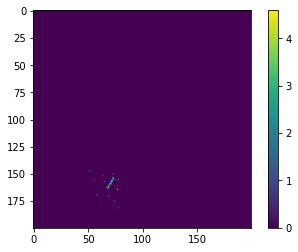

/tmp/ipykernel_23428/777681975.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell_x = x[key][ievt][mask_0]
/tmp/ipykernel_23428/777681975.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell_y = y[key][ievt][mask_0]
/tmp/ipykernel_23428/777681975.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell

suma_ECal:  ()
piplus  Suma ECAL =0.21


No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


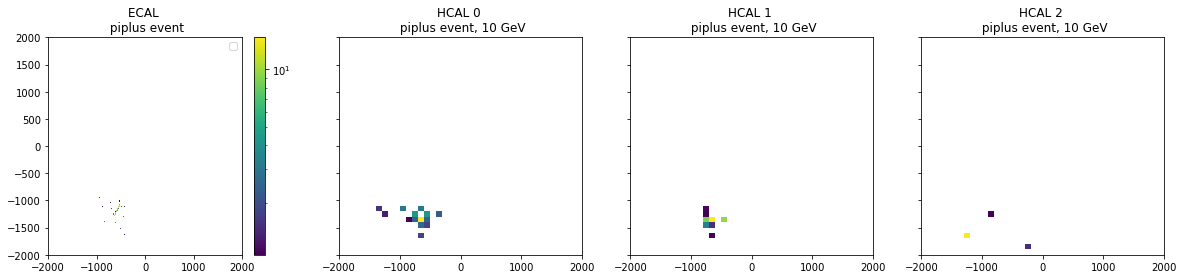

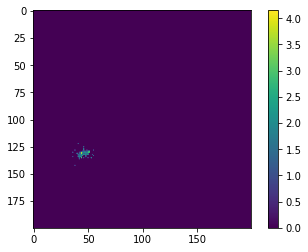

No handles with labels found to put in legend.


suma_ECal:  ()
pi0  Suma ECAL =2.76


No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


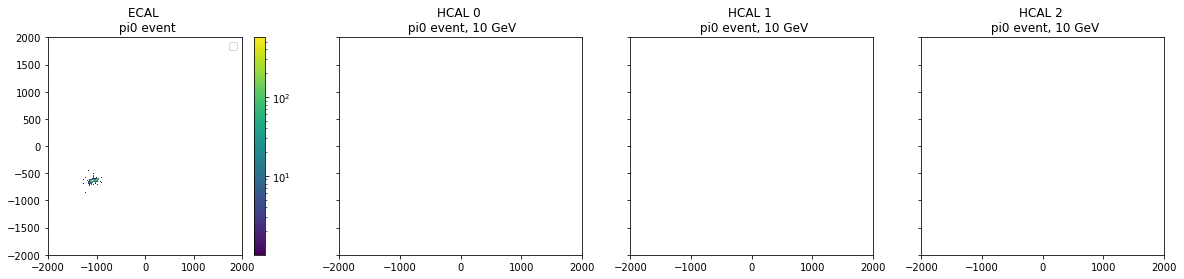

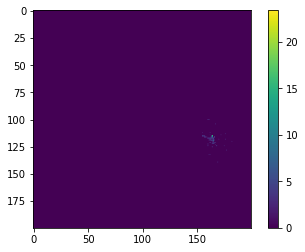

No handles with labels found to put in legend.


suma_ECal:  ()
piplus  Suma ECAL =1.11


No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


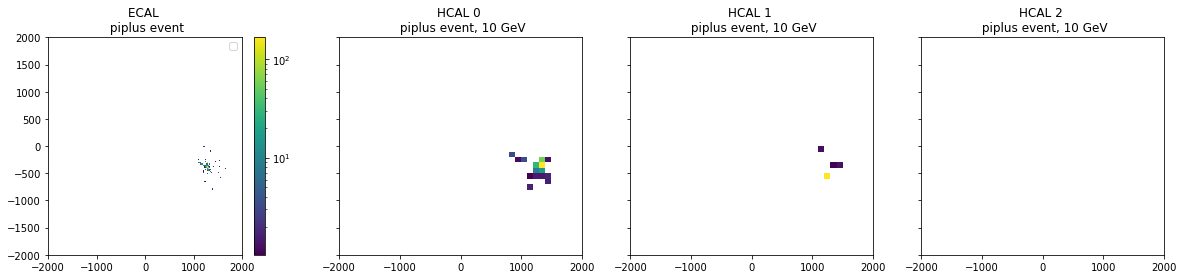

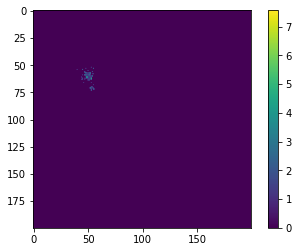

No handles with labels found to put in legend.


suma_ECal:  ()
pi0  Suma ECAL =2.71


No handles with labels found to put in legend.
No handles with labels found to put in legend.


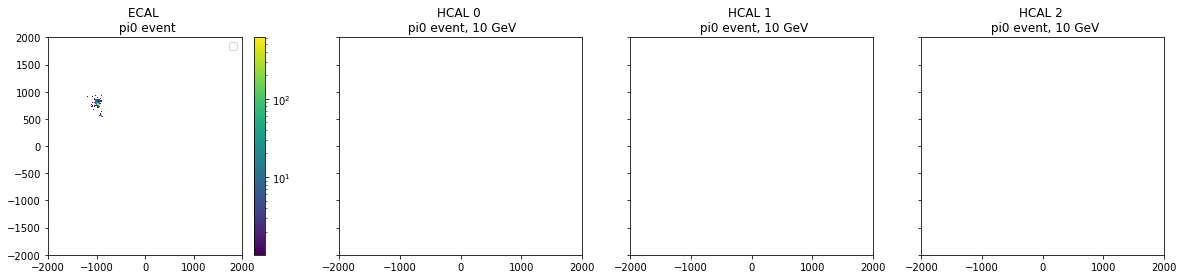

In [46]:
#loop over events
base=[]
image_piplus = []
image_pi0 = []
# ecal = np.array
for ievt in range(2):
    for part_type in ['piplus','pi0']:
        #print(ievt)
        base.append(ievt)
#         base.append(',')

# put save inside the for loop
        key = '%s_EcalEndcapP'%(part_type)
        
        
#        mask = [(E[key][ievt]>0.005) & (E[key][ievt]/np.sum(E[key][ievt])>0.001)]
        mask_0 = [(E[key][ievt]>0.001)]
        
        size = len(E[key][ievt])
        cell_x = x[key][ievt][mask_0]
        cell_y = y[key][ievt][mask_0]
        cell_E = E[key][ievt][mask_0]*1000.0 #(MeV)
        
#         print(np.array(cell_E))
        cell_x = np.array(cell_x)
        cell_y = np.array(cell_y)
        cell_E = np.array(cell_E)
        
        base.append(cell_E)
        # array 200, 200, 0
        array = np.zeros((200,200), dtype=float, order='C')

        for ihit, iE in enumerate(cell_E):
            ix = math.floor((cell_x[ihit]+2000.)/20.)
            iy = math.floor((cell_y[ihit]+2000.)/20.)
            array[ix,iy] = iE
                        
        array = np.rot90(array)
        
        print(array)
        fig = plt.figure()
        plt.imshow(array)
        plt.colorbar()
        plt.grid(False)
        plt.show()
#         image_pi0.append(array)
        fig,ax  = plt.subplots(1,4,figsize=(20,4),sharex=True, sharey=True)

#         c = ax[0].hist2d(cell_x,cell_y, weights=cell_E,label=part_type + ' evt #%i'%(ievt), 
#                      bins=[200,200],range=([[-2000, 2000], [-2000,2000]]))
        c = ax[0].hist2d(cell_x,cell_y, weights=cell_E,label=part_type + ' evt #%i'%(ievt), 
                     bins=[200,200],range=([[-2000, 2000], [-2000,2000]]),norm=LogNorm())
        fig.colorbar(c[3], ax=ax[0])  
        plt.savefig(key)
        
        suma_ECAL = np.sum(E[key][ievt])
        
        print("suma_ECal: ", suma_ECAL.shape)
        print(part_type , ' Suma ECAL =%2.2f'%suma_ECAL)
        #### HCAL 
        key = '%s_HcalHadronEndcap'%(part_type)
        for iz, zbins in enumerate([(3000,3200),(3200,3400),(3400,3600)]):
            mask_0 = [(z[key][ievt]>zbins[0]) & (z[key][ievt]<zbins[1]) & (E[key][ievt]>0.001)]
            if(np.sum(mask_0)<1): continue
            cell_x = x[key][ievt][mask_0]
            cell_y = y[key][ievt][mask_0]
            cell_E = E[key][ievt][mask_0] *1000.0 # MEV
             
            c = ax[iz+1].hist2d(cell_x,cell_y, weights=cell_E,label=part_type + ' evt #%i'%(ievt), 
                    bins=[40,40],range=([[-2000, 2000], [-2000,2000]]),norm=LogNorm())
#             fig.colorbar(c[3], ax=ax[iz+1]) 
#             print(c[3])
#             print(ax)

        ax[0].set_title('ECAL \n %s event'%(part_type))
        for iz in range(3):
            ax[iz+1].set_title('HCAL %i \n %s event, %2.0f GeV'%(iz,part_type,truth[part_type+'_p']))
            ax[0].legend()
            sevt = str(ievt)
            siz = str(iz)
            name = part_type + sevt + siz + ".png"
            plt.savefig(name)

            

#         ax[0].legend()
#         sevt = str(ievt)
#         name = part_type + sevt + ".png"
#         plt.savefig(name)
#         base.append('\n')
        
# np.savetxt('data.csv', base,  fmt='%d',delimiter=',')
# np.savez('data.npz', base, fmt="%d+%d",delimiter=',')
np.atleast_1d(x)
np.savez('data.npz', x=x, y=y, z=z, E=E)

        #for a in ax:
        #    a.set_xticklabels([])
        #    a.set_yticklabels([])
        #plt.subplots_adjust(wspace=0, hspace=0.5)
# x.shape

In [ ]:
#sf_ECAL = 0.253
#sf_HCAL = 0.025
    #print('Energy = %2.3f'%(suma_ECAL/sf_ECAL+suma_HCAL/sf_HCAL))
    ##suma_HCAL = np.sum(E[key][ievt])
    #print(suma_HCAL/sf_HCAL)
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
# https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa

data = np.load('data.npz')

# restore np.load for future normal usage
np.load = np_load_old

In [ ]:
data.files

In [ ]:
data

In [ ]:
x_array = data['x']
y_array = data['y']
z_array = data['z']
E_array = data['E']

# arr_1 = b['array1']

In [ ]:
# type(arr_1)
x_piplusEcal = x_array.tolist()['piplus_EcalEndcapP']
y_piplusEcal = y_array.tolist()['piplus_EcalEndcapP']
z_piplusEcal = z_array.tolist()['piplus_EcalEndcapP']
E_piplusEcal = E_array.tolist()['piplus_EcalEndcapP']

x_piplusHcal = x_array.tolist()['piplus_HcalHadronEndcap']
y_piplusHcal = y_array.tolist()['piplus_HcalHadronEndcap']
z_piplusHcal = z_array.tolist()['piplus_HcalHadronEndcap']
E_piplusHcal = E_array.tolist()['piplus_HcalHadronEndcap']

x_pi0Ecal = x_array.tolist()['pi0_EcalEndcapP']
y_pi0Ecal = y_array.tolist()['pi0_EcalEndcapP']
z_pi0Ecal = z_array.tolist()['pi0_EcalEndcapP']
E_pi0Ecal = E_array.tolist()['pi0_EcalEndcapP']

x_pi0Hcal = x_array.tolist()['pi0_HcalHadronEndcap']
y_pi0Hcal = y_array.tolist()['pi0_HcalHadronEndcap']
z_pi0Hcal = z_array.tolist()['pi0_HcalHadronEndcap']
E_pi0Hcal = E_array.tolist()['pi0_HcalHadronEndcap']

In [ ]:
x_piplusHcal[0].shape

In [ ]:
x_piplusHcal[0]

In [ ]:
plt.scatter(x_piplusHcal[0],y_piplusHcal[0])

In [ ]:
ii=0 
# entry #

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(z_piplusEcal[ii], x_piplusEcal[ii], y_piplusEcal[ii])
ax.scatter(z_piplusHcal[ii], x_piplusHcal[ii], y_piplusHcal[ii] )

plt.show()

In [ ]:
fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(projection='3d')

ax1.scatter(z_pi0Ecal[ii], x_pi0Ecal[ii], y_pi0Ecal[ii])
ax1.scatter(z_pi0Hcal[ii], x_pi0Hcal[ii], y_pi0Hcal[ii])
plt.show()

1. how are the 4 or less images represented in the data?
- Ecal 1 image (z < 3000)
- Hcal 3 images depending on z: (3000,3200), (3200,3400), (3400,3600)

2. What should be the input and output format for the model?
- Input: 1 image(heat map) from Ecal, 3 images(heat map) from Hcal
- Output: (theta, phi, Energy in Ecal, Energy in Hcal, total Energy)

3. i think the data is for just one particle right?
- It has pi0 and pion_plus

4. I need to figure out how the data is structured so that i can setup the model
- multiple entries
- each entry has one pion and one piplus tracks
- one track related 1 images of Ecal and 3 images of Hcal